# Imports

In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import math
import random
import ast
import itertools
import random
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split

from google.colab import drive

In [90]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Load Data

In [92]:
data_path = '/content/drive/Shared drives/RecSys/HybridModel'

datasets = {
  "ml1m": {
      "txt_file": os.path.join(data_path, "ml1m", "ML-1M.txt"),
      "csv_file_fmlp": os.path.join(data_path, "ml1m", "valid_predictions_FMLP_ML1M.csv"),
      "csv_file_linrec": os.path.join(data_path, "ml1m", "valid_predictions_LinRec_ML1M.csv"),
      "test_csv_file_fmlp": os.path.join(data_path, "ml1m", "test_predictions_FMLP_ML1M.csv"),
      "test_csv_file_linrec": os.path.join(data_path, "ml1m", "test_predictions_LinRec_ML1M.csv"),
      "processed_file": os.path.join(data_path, "ml1m", "processed_data_ML1M.pt"),
      "linrec_item_mapping": None,
      "fmlp_item_mapping": None,
      "test_processed_file": os.path.join(data_path, "ml1m", "processed_data_ML1M_test.pt"),
      "model_save_path": os.path.join(data_path, "ml1m", "hybrid_model_ML1M.pth"),
  },
  "beauty": {
      "txt_file": os.path.join(data_path, "beauty", "Beauty.txt"),
      "csv_file_fmlp": os.path.join(data_path, "beauty", "valid_predictions_FMLP_Beauty.csv"),
      "csv_file_linrec": os.path.join(data_path, "beauty", "valid_predictions_LinRec_Beauty.csv"),
      "test_csv_file_fmlp": os.path.join(data_path, "beauty", "test_predictions_FMLP_Beauty.csv"),
      "test_csv_file_linrec": os.path.join(data_path, "beauty", "test_predictions_LinRec_Beauty.csv"),
      "linrec_item_mapping": os.path.join(data_path, "beauty", "id2item_linrec_beauty.csv"),
      "fmlp_item_mapping": os.path.join(data_path, "beauty", "id2item_fmlp_beauty.csv"),
      "processed_file": os.path.join(data_path, "beauty", "processed_data_beauty.pt"),
      "test_processed_file": os.path.join(data_path, "beauty", "processed_data_beauty_test.pt"),
      "model_save_path": os.path.join(data_path, "beauty", "hybrid_model_beauty.pth"),
  }
}

In [93]:
def compute_features(seq, fmlp_top10, linrec_top10):
    length = float(len(seq))
    unique_items = set(seq)
    unique_count = float(len(unique_items))

    counts = {}
    for item in seq:
        counts[item] = counts.get(item, 0) + 1

    entropy = 0.0
    for count in counts.values():
        p = count / length
        entropy -= p * math.log2(p)

    max_freq_ratio = max(counts.values()) / length
    avg_freq = length / unique_count if unique_count > 0 else 0

    fmlp_set = set(fmlp_top10)
    linrec_set = set(linrec_top10)
    intersection_count = len(fmlp_set.intersection(linrec_set))
    union_count = len(fmlp_set.union(linrec_set))
    jaccard = intersection_count / union_count if union_count > 0 else 0.0

    # return [length, entropy, unique_count, max_freq_ratio, intersection_count, jaccard]   # see shap values and features selection in the paper.
    return [length, entropy, unique_count]

In [94]:
def compute_reciprocal_rank(pred_list, ground_truth):
    try:
        idx = pred_list.index(ground_truth)
        return 1.0 / (idx + 1)
    except ValueError:
        return 0.0

In [95]:
# In beauty dataset, we needed to use a mapping original-item-id to model-used-item-id due to how FMLP model changing the ids.
def load_item_mapping(mapping_file):
    mapping = {}
    df = pd.read_csv(mapping_file)
    if 'internal_item_id' in df.columns and 'original_item_id' in df.columns:
        for idx, row in df.iterrows():
            mapping[str(row['internal_item_id'])] = str(row['original_item_id'])
    else:
        for idx, row in df.iterrows():
            mapping[str(row['new_item_id'])] = str(row['original_item_id'])
    return mapping

In [96]:
def load_data(txt_file, fmlp_train, fmlp_test, linrec_train, linrec_test, processed_file, item_mapping_fmlp_file, item_mapping_linrec_file):
    print("Processing raw data from files:", txt_file)

    # Load item mappings if provided(Beauty dataset)
    if item_mapping_fmlp_file is not None and os.path.exists(item_mapping_fmlp_file):
        item_mapping_fmlp = load_item_mapping(item_mapping_fmlp_file)
    else:
        item_mapping_fmlp = {}
    if item_mapping_linrec_file is not None and os.path.exists(item_mapping_linrec_file):
        item_mapping_linrec = load_item_mapping(item_mapping_linrec_file)
    else:
        item_mapping_linrec = {}

    user_features = {}
    user_sequences = {}
    with open(txt_file, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tokens = line.strip().split()
        if len(tokens) < 2:
            continue

        user_id = int(tokens[0]) - 1
        seq = list(map(int, tokens[1:]))
        if item_mapping_fmlp:
            seq = [item_mapping_fmlp.get(str(item)) for item in seq]
        seq = seq[:len(seq)-2]  # removing the validation and test which due to using leave-2-out are allways the last 2
        user_sequences[user_id] = seq

    df_train_fmlp = pd.read_csv(fmlp_train)
    df_test_fmlp = pd.read_csv(fmlp_test)
    df_train_linrec = pd.read_csv(linrec_train)
    df_test_linrec = pd.read_csv(linrec_test)

    counter_linrec = 0
    counter_fmlp = 0
    counter_both = 0
    counter_nither = 0

    data = []

    for idx, row in df_train_fmlp.iterrows():
        user_id = int(row['user_id'])

        # Process FMLP train predictions and apply item mapping if available
        fmlp_train_preds = ast.literal_eval(row['predicted_top20'])[:10]
        train_ground_truth = int(row['ground_truth'])
        if item_mapping_fmlp:
            fmlp_train_preds = [item_mapping_fmlp.get(str(item)) for item in fmlp_train_preds]
            train_ground_truth = item_mapping_fmlp.get(str(row['ground_truth']))
        score_train_fmlp = compute_reciprocal_rank(fmlp_train_preds, train_ground_truth)

        # Process LinRec train predictions and apply mapping if available
        row_train_linrec = df_train_linrec.iloc[idx]
        linrec_train_preds = ast.literal_eval(row_train_linrec['predicted_top20'])
        if item_mapping_linrec:
            linrec_train_preds = [item_mapping_linrec.get(str(item)) for item in linrec_train_preds]
        score_train_linrec = compute_reciprocal_rank(linrec_train_preds, train_ground_truth)

        # Process FMLP test predictions
        row_test_fmlp = df_test_fmlp.iloc[idx]
        fmlp_test_preds = ast.literal_eval(row_test_fmlp['predicted_top20'])[:10]
        if item_mapping_fmlp:
            fmlp_test_preds = [item_mapping_fmlp.get(str(item)) for item in fmlp_test_preds]
        if item_mapping_fmlp:
          test_ground_truth = item_mapping_fmlp.get(str(row_test_fmlp['ground_truth']))
        else:
          test_ground_truth = int(row_test_fmlp['ground_truth'])

        # Process LinRec test predictions
        row_test_linrec = df_test_linrec.iloc[idx]
        linrec_test_preds = ast.literal_eval(row_test_linrec['predicted_top20'])
        if item_mapping_linrec:
            linrec_test_preds = [item_mapping_linrec.get(str(item)) for item in linrec_test_preds]


        toIgnore = False
        target_alpha = None

        if score_train_linrec > score_train_fmlp:
            target_alpha = 1.0
            counter_linrec += 1
        elif score_train_linrec < score_train_fmlp:
            target_alpha = 0.0
            counter_fmlp += 1
        elif score_train_linrec == score_train_fmlp and score_train_linrec != 0.0:  # choose randmolly if both got the same score
              # target_alpha = 0.5   # Was discussed in the paper for an alternative approch insted of choosing at random.
              target_alpha = random.choice([0.0, 1.0])
              counter_both += 1
        else:
            toIgnore = True  # We do not put inside the train/val set rows where nither of the model could predict in his top10 cus its not adding any information.
            counter_nither += 1

        target_hybrid = max(score_train_linrec, score_train_fmlp)

        train_sequence = user_sequences.get(user_id, [])
        train_features = compute_features(train_sequence, fmlp_test_preds, linrec_train_preds)

        test_sequence = train_sequence + [train_ground_truth]   # Test sequence is the same as the original sequence but we add the ground truth.
        test_features = compute_features(test_sequence, fmlp_test_preds, linrec_train_preds)


        data.append({
            'position': idx,
            'user_id': user_id,
            'train_sequence': train_sequence,
            'train_features': train_features,
            'test_sequence': test_sequence,
            'test_features': test_features,
            'score_fmlp': score_train_fmlp,
            'score_linrec': score_train_linrec,
            'target_alpha': target_alpha,
            'target_hybrid': target_hybrid,
            'train_fmlp_preds': fmlp_train_preds,
            'train_linrec_preds': linrec_train_preds,
            'train_ground_truth': train_ground_truth,
            'test_fmlp_preds': fmlp_test_preds,
            'test_linrec_preds': linrec_test_preds,
            'test_ground_truth': test_ground_truth,
            'toIgnore': toIgnore
        })

    X_train = torch.tensor([d['train_features'] for d in data if not d['toIgnore']], dtype=torch.float32) # We want to train only with data we know found by at least one model
    print("train length: " + str(len(X_train)))
    y_train = torch.tensor([d['target_alpha'] for d in data if not d['toIgnore']], dtype=torch.float32).unsqueeze(1)
    X_test = torch.tensor([d['test_features'] for d in data], dtype=torch.float32)    # We want to test however on all the sequence in the test.
    print("test length: " + str(len(X_test)))
    print(" ")

    print("just linrec: " + str(counter_linrec))
    print("just fmlp: " + str(counter_fmlp))
    print("both: " + str(counter_both))
    print("nither: " + str(counter_nither))

    data_dict = {
        'X_train': X_train,
        'y_train': y_train,
        'raw_data': data,
        'X_test': X_test,
    }
    torch.save(data_dict, processed_file)
    csv_save_path = processed_file.replace('.pt', '.csv')
    df_data = pd.DataFrame(data)
    df_data.to_csv(csv_save_path, index=False)
    print("Processed data saved to", processed_file)
    return data_dict

# Hybrid Model

In [97]:
class HybridModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(HybridModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Prediction Merging

In [98]:
# The main idea of the algorithm is that we want to choose at any indext 1-10 which prediction to take Linrec or FMLP and we do it by moving simultaneously on both list.
# We are also make sure not to put duplicate predictions.

def combine_predictions(linrec_preds, fmlp_preds, alpha, top_n, noise_range):
    final_list = []
    linrec_idx = 0
    fmlp_idx = 0

    # We are adding noise which serve as regularization to help overcome overfitting.
    noise = random.uniform(-noise_range, noise_range)
    alpha_noisy = alpha + noise
    alpha_noisy = max(0.0, min(alpha_noisy, 1.0))

    while len(final_list) < top_n:
        if random.random() < alpha_noisy:  # for a given, we want to choose Linrec in alpha% and to choose FMLP in (1-alpha)%
            candidate = None
            # Attempt to pick from LinRec
            while linrec_idx < len(linrec_preds):
                if linrec_preds[linrec_idx] not in final_list:
                    candidate = linrec_preds[linrec_idx]
                    linrec_idx += 1
                    break
                linrec_idx += 1

            # Fallback: if LinRec is exhausted or no new candidate, try FMLP
            if candidate is None:
                while fmlp_idx < len(fmlp_preds):
                    if fmlp_preds[fmlp_idx] not in final_list:
                        candidate = fmlp_preds[fmlp_idx]
                        fmlp_idx += 1
                        break
                    fmlp_idx += 1
        else:
            candidate = None
            # Attempt to pick from FMLP
            while fmlp_idx < len(fmlp_preds):
                if fmlp_preds[fmlp_idx] not in final_list:
                    candidate = fmlp_preds[fmlp_idx]
                    fmlp_idx += 1
                    break
                fmlp_idx += 1

            # Fallback: if FMLP is exhausted or no new candidate, try LinRec
            if candidate is None:
                while linrec_idx < len(linrec_preds):
                    if linrec_preds[linrec_idx] not in final_list:
                        candidate = linrec_preds[linrec_idx]
                        linrec_idx += 1
                        break
                    linrec_idx += 1

        if candidate is None:
            break

        final_list.append(candidate)


    return final_list[:top_n]


# Training and Evaluation

In [99]:
def split_X_train(raw_data):
    raw_data_filtered = [d for d in raw_data if not d['toIgnore']]

    # This comment section is how we choosed balanced data or balanced data with a little bit more to FMLP.
    # data_alpha0 = [d for d in raw_data_filtered if d['target_alpha'] == 0.0]
    # data_alpha1 = [d for d in raw_data_filtered if d['target_alpha'] == 1.0]

    # min_size = min(len(data_alpha0), len(data_alpha1))
    # data_alpha0_sampled = random.sample(data_alpha0, min_size+int(0.1*min_size))  # creating a more balance dataset of about 60/40
    # data_alpha1_sampled = random.sample(data_alpha1, min_size)

    # # Combine into one balanced list
    # balanced_data = data_alpha0_sampled + data_alpha1_sampled

    balanced_data = raw_data_filtered

    X_list = []
    y_list = []
    for entry in balanced_data:
        X_list.append(entry["train_features"])
        y_list.append(entry["target_alpha"])

    X_np = np.array(X_list, dtype=np.float32)
    y_np = np.array(y_list, dtype=np.float32)

    train_indices, val_indices = train_test_split(
        np.arange(len(X_np)),
        test_size=0.2,
        random_state=42,
        stratify=y_np
    )

    X_train_np = X_np[train_indices]
    y_train_np = y_np[train_indices]
    X_val_np   = X_np[val_indices]
    y_val_np   = y_np[val_indices]

    raw_data_train = [balanced_data[i] for i in train_indices]
    raw_data_val   = [balanced_data[i] for i in val_indices]

    X_train = torch.from_numpy(X_train_np)
    y_train = torch.from_numpy(y_train_np).unsqueeze(1)
    X_val = torch.from_numpy(X_val_np)
    y_val = torch.from_numpy(y_val_np).unsqueeze(1)

    return X_train, y_train, X_val, y_val, raw_data_train, raw_data_val

In [100]:
def evaluate_model(model, X, raw_data, noise_range, mode):
  model.eval()
  with torch.no_grad():
      predicted_alphas_tensor = model(X)
      predicted_alphas_tensor = torch.sigmoid(predicted_alphas_tensor)
  predicted_alphas = predicted_alphas_tensor.cpu().numpy().flatten()

  final_combined_predictions = {}
  for idx, user_data in enumerate(raw_data):
      if mode == "train":
        linrec_preds = user_data.get('train_linrec_preds', [])
        fmlp_preds = user_data.get('train_fmlp_preds', [])
      else:
        linrec_preds = user_data.get('test_linrec_preds', [])
        fmlp_preds = user_data.get('test_fmlp_preds', [])

      alpha = predicted_alphas[idx]
      final_combined_predictions[user_data['user_id']]  = combine_predictions(linrec_preds, fmlp_preds, alpha, 10, noise_range)

  total_mrr = 0.0
  total_ndcg = 0.0
  n_users = len(raw_data)
  for user_data in raw_data:
      uid = user_data['user_id']
      if mode == "train":
        gt = user_data['train_ground_truth']
      else:
        gt = user_data['test_ground_truth']
      preds = final_combined_predictions[uid][:10]
      mrr, ndcg = compute_metrics(preds, gt, 10)
      total_mrr += mrr
      total_ndcg += ndcg

  avg_mrr = total_mrr / n_users
  avg_ndcg = total_ndcg / n_users
  return final_combined_predictions, avg_mrr, avg_ndcg, predicted_alphas

In [101]:
def train_hybrid_model(raw_data, n_trials):

    X_train, y_train, X_val, y_val, raw_data_train, raw_data_val = split_X_train(raw_data)

    best_score = -float('inf')  # Higher composite score is better.
    best_params = {}
    best_model = None

    print("Starting Random Search for hyperparameter optimization based on MRR and NDCG...")
    for trial in range(n_trials):
        lr = 10 ** random.uniform(-5, -1)
        hidden_dim = random.choice([16, 32, 64, 128])
        epochs = random.choice([5, 15, 25, 50, 100, 250])
        pos_weight = random.uniform(0.25, 1.5)
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]))
        noise_range = random.uniform(0, 0.25)

        model = HybridModel(input_dim=X.shape[1], hidden_dim=hidden_dim)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()

        _, avg_mrr, avg_ndcg, _ = evaluate_model(model, X_val, raw_data_val, noise_range, "train")
        composite_score = (avg_mrr + avg_ndcg) / 2.0

        print(f"Trial {trial+1}/{n_trials}: lr={lr:.4f}, hidden_dim={hidden_dim}, epochs={epochs}, composite={composite_score:.4f}")

        # This comment section is when we used the loss of criterion to choose the best model before moving into the composite socre
        # val_outputs = model(X_val)
        # val_loss = criterion(val_outputs, y_val)

        # print(f"Trial {trial+1}/{n_trials}: lr={lr:.4f}, hidden_dim={hidden_dim}, epochs={epochs}, loss={val_loss.item():.4f}")
        #       f"lavg_mrr={avg_mrr:.4f}, avg_ndcg={avg_ndcg:.4f}, composite={composite_score:.4f}")

        if composite_score > best_score:
            best_score = composite_score
            best_params = {'lr': lr, 'hidden_dim': hidden_dim, 'epochs': epochs, 'pos_weight': pos_weight, "noise_range": noise_range}
            best_model = model

    return X_train, best_model, best_score, best_params


In [102]:
def compute_metrics(preds, ground_truth, k=10):
    try:
        idx = preds.index(ground_truth)
        if idx < k:
            mrr = 1.0 / (idx + 1)
            ndcg = 1.0 / math.log2(idx + 2)
        else:
            mrr = 0.0
            ndcg = 0.0
    except ValueError:
        mrr = 0.0
        ndcg = 0.0
    return mrr, ndcg


# Runing

In [103]:
def run_hybrid_model_for_dataset(dataset_name, raw_data, X_test):
    print(f"\n========== Running Hybrid Model for Dataset: {dataset_name}")

    # --- Training ---
    X_train, best_model, best_loss, best_params = train_hybrid_model(raw_data, 500)
    print("Best hyperparameters for", dataset_name, ":", best_params, "with loss:", best_loss)
    torch.save(best_model.state_dict(), paths["model_save_path"])
    print("Hybrid model saved at:", paths["model_save_path"])
    print(" ")

    # --- Evaluation ---
    final_combined_predictions, avg_mrr, avg_ndcg, predicted_alphas = evaluate_model(
        best_model,
        X_test,
        raw_data,
        best_params["noise_range"],
        "test"
    )
    seq_lengths = X_test[:, 0].cpu().numpy()

    return {
        "X_train": X_train,
        "X_test": X_test,
        "final_combined_predictions": final_combined_predictions,
        "avg_mrr": avg_mrr,
        "avg_ndcg": avg_ndcg,
        "predicted_alphas": predicted_alphas,
        "seq_lengths": seq_lengths,
        "best_params": best_params,
        "best_model": best_model
    }


In [104]:
results = {}
for dataset_name, paths in datasets.items():
     # --- Data Loading ---
    data_dict= load_data(
        paths["txt_file"],
        paths["csv_file_fmlp"],
        paths["test_csv_file_fmlp"],
        paths["csv_file_linrec"],
        paths["test_csv_file_linrec"],
        paths["processed_file"],
        paths["fmlp_item_mapping"],
        paths["linrec_item_mapping"],
    )

    X = data_dict['X_train']
    y = data_dict['y_train']
    raw_data = data_dict['raw_data']
    X_test = data_dict['X_test']



    results[dataset_name] = run_hybrid_model_for_dataset(dataset_name, raw_data, X_test)

Processing raw data from files: /content/drive/Shared drives/RecSys/HybridModel/ml1m/ML-1M.txt
train length: 5176
test length: 6040
 
just linrec: 1090
just fmlp: 2616
both: 1470
nither: 864
Processed data saved to /content/drive/Shared drives/RecSys/HybridModel/ml1m/processed_data_ML1M.pt

========== Running Hybrid Model for Dataset: ml1m
Starting Random Search for hyperparameter optimization based on MRR and NDCG...
Trial 1/500: lr=0.0160, hidden_dim=128, epochs=5, composite=0.6547
Trial 2/500: lr=0.0333, hidden_dim=128, epochs=15, composite=0.6037
Trial 3/500: lr=0.0001, hidden_dim=16, epochs=250, composite=0.6019
Trial 4/500: lr=0.0001, hidden_dim=128, epochs=100, composite=0.6164
Trial 5/500: lr=0.0000, hidden_dim=64, epochs=5, composite=0.6489
Trial 6/500: lr=0.0013, hidden_dim=16, epochs=15, composite=0.6102
Trial 7/500: lr=0.0091, hidden_dim=32, epochs=250, composite=0.6304
Trial 8/500: lr=0.0980, hidden_dim=64, epochs=15, composite=0.6012
Trial 9/500: lr=0.0000, hidden_dim=32,

In [105]:
for dataset_name, paths in datasets.items():
   print("Average MRR@10 on", dataset_name, ":", f"{results[dataset_name]['avg_mrr']:.4f}")
   print("Average NDCG@10 on", dataset_name, ":", f"{results[dataset_name]['avg_ndcg']:.4f}")

Average MRR@10 on ml1m : 0.5158
Average NDCG@10 on ml1m : 0.5847
Average MRR@10 on beauty : 0.2967
Average NDCG@10 on beauty : 0.3412


# Plots

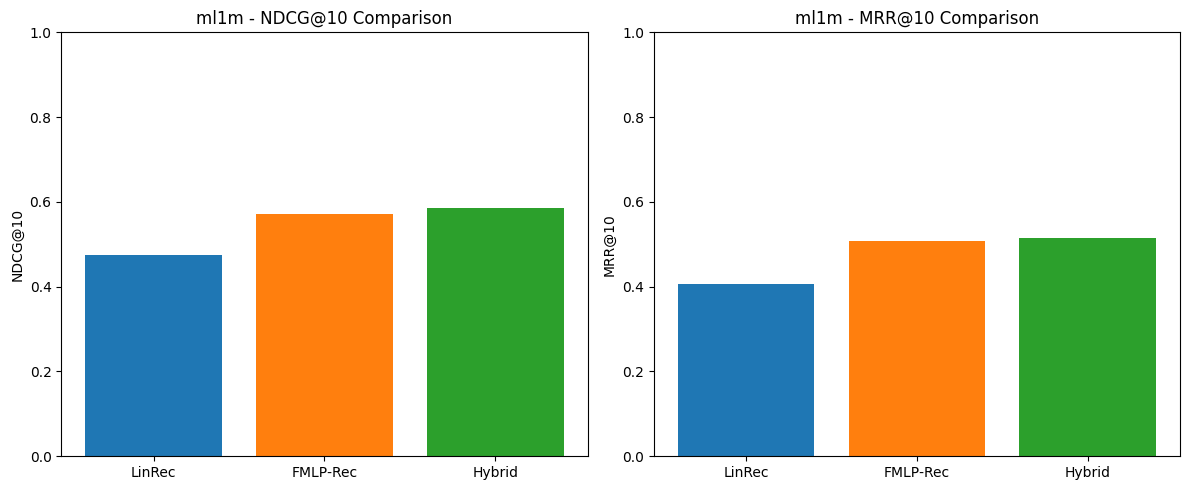

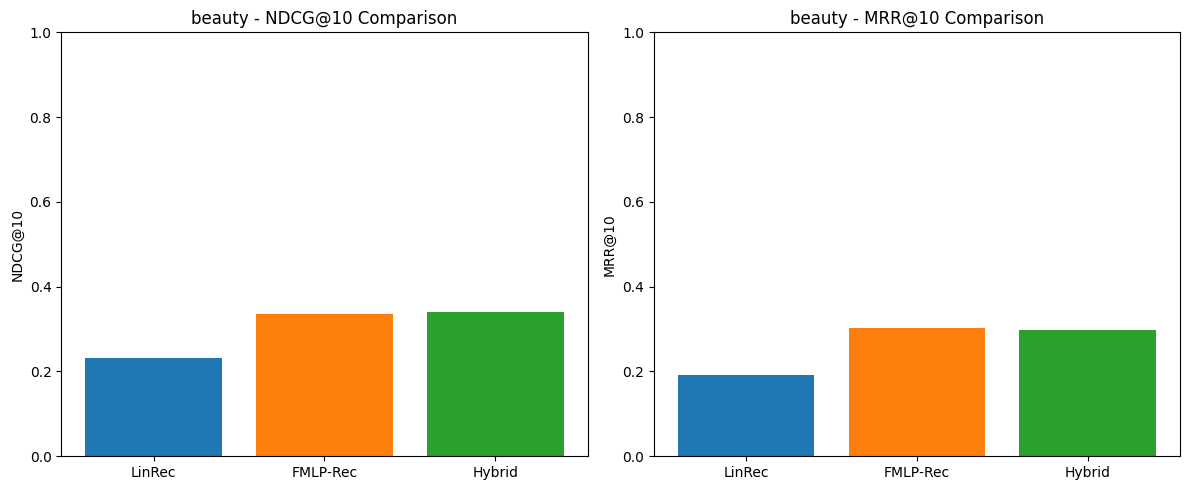

In [106]:
import matplotlib.pyplot as plt

def plot_model_comparison(ndcg_linrec, mrr_linrec, ndcg_fmlp, mrr_fmlp, ndcg_hybrid, mrr_hybrid, dataset_name="Dataset"):
    models = ['LinRec', 'FMLP‑Rec', 'Hybrid']
    ndcg_values = [ndcg_linrec, ndcg_fmlp, ndcg_hybrid]
    mrr_values = [mrr_linrec, mrr_fmlp, mrr_hybrid]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # NDCG@10 Plot
    ax[0].bar(models, ndcg_values, color=colors)
    ax[0].set_title(f'{dataset_name} - NDCG@10 Comparison')
    ax[0].set_ylabel('NDCG@10')
    ax[0].set_ylim([0, 1])

    # MRR@10 Plot
    ax[1].bar(models, mrr_values, color=colors)
    ax[1].set_title(f'{dataset_name} - MRR@10 Comparison')
    ax[1].set_ylabel('MRR@10')
    ax[1].set_ylim([0, 1])

    plt.tight_layout()
    plt.show()

scores = {
    "ml1m": {
        "LinRec": {
          "mrr": 0.4062,
          "ndcg": 0.4736
        },
        "FMLP": {
          "mrr": 0.5089,
          "ndcg": 0.5724
        }
    },
    "beauty": {
      "LinRec": {
        "mrr": 0.1906,
        "ndcg": 0.2327
      },
      "FMLP": {
        "mrr": 0.3031,
        "ndcg": 0.3358
      }
    }
}

for dataset_name, _ in datasets.items():
  plot_model_comparison(scores[dataset_name]['LinRec']['ndcg'], scores[dataset_name]['LinRec']['mrr'],
                        scores[dataset_name]['FMLP']['ndcg'], scores[dataset_name]['FMLP']['mrr'],
                        results[dataset_name]['avg_ndcg'], results[dataset_name]['avg_mrr'],
                        dataset_name=dataset_name)


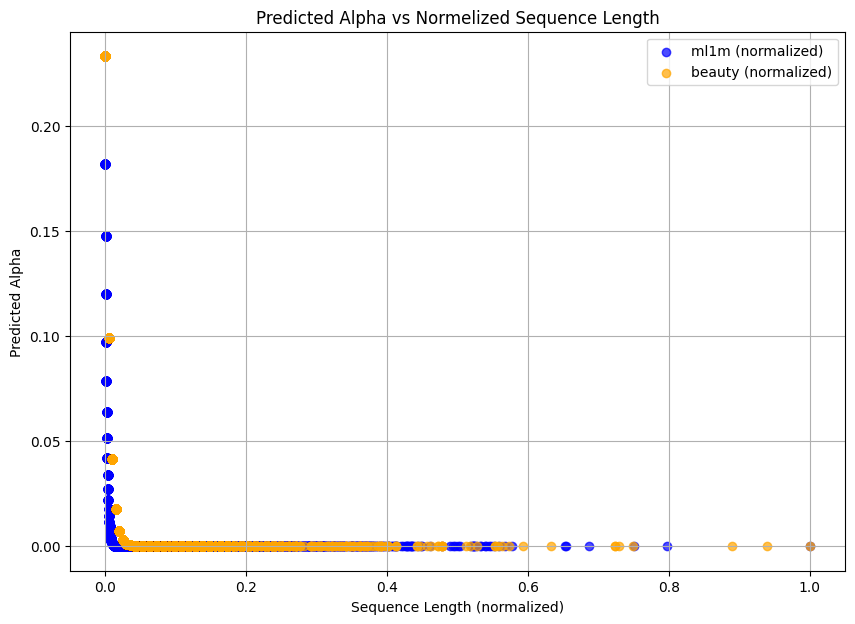

In [149]:
def min_max_normalize(values):
    return (values - np.min(values)) / (np.max(values) - np.min(values))

def plot_normalized_scatter(results, feature_name):
    plt.figure(figsize=(10, 7))
    colors = ['blue', 'orange']

    for i, (dataset_name, result) in enumerate(results.items()):
        norm_seq_lengths = min_max_normalize(result["seq_lengths"])
        plt.scatter(norm_seq_lengths, result["predicted_alphas"],
                    color=colors[i], alpha=0.7, label=f'{dataset_name} (normalized)')

    plt.xlabel(f'{feature_name} (normalized)')
    plt.ylabel('Predicted Alpha')
    plt.title(f'Predicted Alpha vs Normelized {feature_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage
plot_normalized_scatter(results, "Sequence Length")


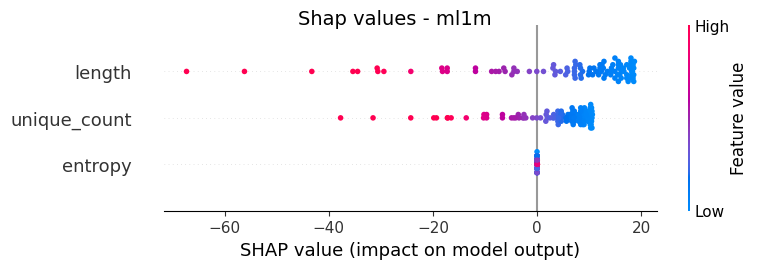

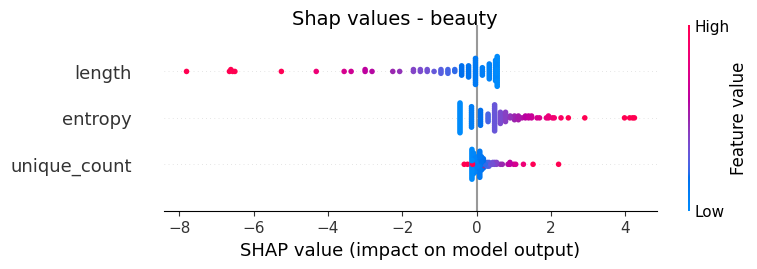

In [108]:
import shap

# In the paper we intreduced the shap on all 6 features, here u can see the shap on the remained 3 after removing the other 3.
def shapAnalysis(X_train, X_test, best_model, dataset_name):
  best_model.eval()

  background = X_train[:500].detach()
  X_explain = X_test[:100].detach()

  explainer = shap.DeepExplainer(best_model, background)
  shap_values = explainer.shap_values(X_explain, check_additivity=False)
  X_explain_np = X_explain.cpu().numpy()

  shap_values_squeezed = np.squeeze(shap_values)
  shap.summary_plot(shap_values_squeezed, X_explain_np, feature_names=["length", "entropy", "unique_count", "max_freq_ratio", "intersection_count", "jaccard"], show=False)

  plt.gcf().suptitle(f"Shap values - {dataset_name}", fontsize=14)
  plt.show()


for dataset_name, _ in datasets.items():
  shapAnalysis(results[dataset_name]["X_train"], results[dataset_name]["X_test"], results[dataset_name]["best_model"], dataset_name)
